In [20]:
from __future__ import print_function 
import sys
sys.setrecursionlimit(10**6)
experiment_setup_name = "tutorial.gym.atari.hierarchical.v0"


#gym game title
GAME_TITLE = 'BankHeist-v0'

#how many parallel game instances can your machine tolerate
N_PARALLEL_GAMES = 25

#how long is one replay session from a batch
#since we have window-like memory (no recurrent layers), we can use relatively small session weights
replay_seq_len = 100


#theano device selection. GPU is, as always, in preference, but not required
%env THEANO_FLAGS='device=gpu1'



env: THEANO_FLAGS='device=gpu1'


In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

[2016-06-06 20:59:35,902] Making new env: BankHeist-v0


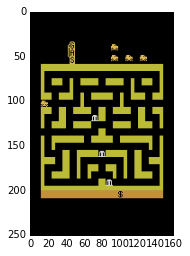

In [3]:
import gym
atari = gym.make(GAME_TITLE)
atari.reset()
plt.imshow(atari.render('rgb_array'))

### Game Parameters
* observation dimensions, actions, etc

In [4]:
n_actions = atari.action_space.n
observation_shape = (None,)+atari.observation_space.shape
action_names = atari.get_action_meanings()
print(action_names)

['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [5]:
del atari

# Agent

In [7]:
from controller_class import Controller

controller = Controller(observation_shape,n_actions)

In [8]:
from metacontroller_class import MetaController


metacontroller = MetaController(controller)

In [9]:
from agentnet.utils.layers import get_layer_dtype

#a nice pythonic interface
def step(env_observation, 
         prev_memories = 'zeros',
         batch_size = N_PARALLEL_GAMES,):
    """ returns actions and new states given observation and prev state
    Prev state in default setup should be [prev window,]"""
    
    if prev_memories == 'zeros':
        controller_mem = metacontroller_mem = 'zeros'
        meta_inp = np.zeros((batch_size,)+tuple(metacontroller.observation_shape[1:]),dtype='float32')
        itr = -1
        #goal will be defined by "if itr ==0" clause
    else:
        pivot = len(controller.agent.state_variables)    
        controller_mem, metacontroller_mem = prev_memories[:pivot],prev_memories[pivot:-4]
        meta_inp, goal, meta_V, [itr] = prev_memories[-4:]
        
    itr = (itr+1)%metacontroller.period
    
    if itr==0:
        goal,metacontroller_mem,meta_V = metacontroller.step(meta_inp,metacontroller_mem,batch_size)

    
    action,controller_mem,meta_inp = controller.step(env_observation,goal,controller_mem,batch_size)
    
    
    new_memories = controller_mem + metacontroller_mem + [meta_inp, goal,meta_V, [itr] ]
    
    return action, new_memories
    
    

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* We define a small container that stores
 * game emulators
 * last agent observations
 * agent memories at last time tick
* This allows us to instantly continue a session from where it stopped



* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf

In [10]:
from agentnet.experiments.openai_gym.pool import GamePool

pool = GamePool(GAME_TITLE, N_PARALLEL_GAMES)


[2016-06-06 21:00:04,659] Making new env: BankHeist-v0
[2016-06-06 21:00:04,683] Making new env: BankHeist-v0
[2016-06-06 21:00:04,706] Making new env: BankHeist-v0
[2016-06-06 21:00:04,729] Making new env: BankHeist-v0
[2016-06-06 21:00:04,752] Making new env: BankHeist-v0
[2016-06-06 21:00:04,775] Making new env: BankHeist-v0
[2016-06-06 21:00:04,797] Making new env: BankHeist-v0
[2016-06-06 21:00:04,821] Making new env: BankHeist-v0
[2016-06-06 21:00:04,844] Making new env: BankHeist-v0
[2016-06-06 21:00:04,866] Making new env: BankHeist-v0
[2016-06-06 21:00:04,889] Making new env: BankHeist-v0
[2016-06-06 21:00:04,912] Making new env: BankHeist-v0
[2016-06-06 21:00:04,935] Making new env: BankHeist-v0
[2016-06-06 21:00:04,958] Making new env: BankHeist-v0
[2016-06-06 21:00:04,981] Making new env: BankHeist-v0
[2016-06-06 21:00:05,004] Making new env: BankHeist-v0
[2016-06-06 21:00:05,027] Making new env: BankHeist-v0
[2016-06-06 21:00:05,049] Making new env: BankHeist-v0
[2016-06-0

In [11]:
%%time
observation_log,action_log,reward_log,_,_,_  = pool.interact(step,50)

print(np.array(action_names)[np.array(action_log)[:3,:5]])

[['RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT']
 ['RIGHT' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT']
 ['DOWNLEFTFIRE' 'RIGHT' 'RIGHT' 'RIGHT' 'RIGHT']]
CPU times: user 4.06 s, sys: 616 ms, total: 4.67 s
Wall time: 4.76 s


# experience replay pool

Since our network exists in a theano graph and OpenAI gym doesn't, we shall train out network via experience replay.

To do that in AgentNet, one can use a SessionPoolEnvironment.

It's simple: you record new sessions using `interact(...)`, and than immediately train on them.

1. Interact with Atari, get play sessions
2. Store them into session environment
3. Train on them
4. Repeat


In [12]:
#Create an environment with all default parameters
from agentnet.environment import SessionPoolEnvironment
controller_env = SessionPoolEnvironment(
    observations = controller.agent.observation_layers,
    actions=controller.resolver,
    agent_memories=controller.agent.agent_states)


metacontroller_env = SessionPoolEnvironment(
    observations = metacontroller.agent.observation_layers,
    actions=metacontroller.resolver,
    agent_memories=metacontroller.agent.agent_states)

In [13]:
def update_envs(controller_env,metacontroller_env,pool,
                n_steps=100,split_into = 4):
    """ a function that creates new sessions and ads them into the pool
    throwing the old ones away entirely for simplicity"""
    assert n_steps%split_into == 0

    
    #get interaction sessions
    observation_log,action_tensor,extrinsic_reward_log,memory_log,is_alive_tensor,_= pool.interact(step,n_steps=n_steps)
    batch_size = observation_log.shape[0]
    
    #parse memory seq
    #UNUSED pivot = len(controller.agent.state_variables)
    #UNUSED controller_mem_log, metacontroller_mem_log = memory_log[:pivot],memory_log[pivot:-4]
    meta_obs_log, goal_log,meta_V, [itr] = memory_log[-4:]
    
    #parse pre-experience memory states 
    preceding_memory_states = list(pool.prev_memory_states)
    pivot = len(controller.agent.state_variables)
    controller_preceding_states = preceding_memory_states[:pivot]
    metacontroller_preceding_states = preceding_memory_states[pivot:-4]

    ###CONTROLLER###
    #load them into experience replay environment for controller
    
    #controller_preceding_states =!!!!!!!!!!!!!!!!!!!!!!!!!!!
    ctrl_shape = (batch_size*split_into,n_steps/split_into)
    
    intrinsic_rewards = np.concatenate([np.zeros([meta_V.shape[0],1]), np.diff(meta_V,axis=1)],axis=1)
    controller_env.load_sessions([observation_log.reshape(ctrl_shape+observation_shape[1:]),
                                  goal_log.reshape(ctrl_shape)],
                      action_tensor.reshape(ctrl_shape),
                      intrinsic_rewards.reshape(ctrl_shape),
                      is_alive_tensor.reshape(ctrl_shape),
                      #controller_preceding_states
                                )
    
    
    ###METACONTROLLER###
    #separate case for metacontroller
    extrinsic_reward_sums = extrinsic_reward_log.reshape([batch_size,-1,metacontroller.period]).sum(axis=-1)
    metacontroller_env.load_sessions(meta_obs_log[:,itr==0],
                      goal_log[:,itr==0],
                      extrinsic_reward_sums,
                      is_alive_tensor[:,itr==0],
                      metacontroller_preceding_states)


In [14]:
#load first  sessions
update_envs(controller_env,metacontroller_env,pool,replay_seq_len)

A more sophisticated way of training is to store a large pool of sessions and train on random batches of them. 
* Why that is expected to be better - http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html
* Or less proprietary - https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

To do that, one might make use of
* ```env.load_sessions(...)``` - load new sessions
* ```env.get_session_updates(...)``` - does the same thing via theano updates (advanced)
* ```batch_env = env.sample_session_batch(batch_size, ...)``` - create an experience replay environment that contains batch_size random sessions from env (rerolled each time). Should be used in training instead of env.
* ```env.select_session_batch(indices)``` does the same thing deterministically.


# Interacting with environment
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

### Training via experience replay

* We use agent we have created to replay environment interactions inside Theano
* to than train on the replayed sessions via theano gradient propagation
* this is essentially basic Lasagne code after the following cell

In [15]:
from lasagne.regularization import regularize_network_params, l2
from agentnet.learning import qlearning_n_step

def get_loss(env,agent):
    #get agent's Qvalues obtained via experience replay
    _,_,_,_,qvalues_seq = agent.get_sessions(
        env,
        initial_hidden = env.preceding_agent_memories,
        session_length=replay_seq_len,
        batch_size=env.batch_size,
        optimize_experience_replay=True,
    )

    scaled_reward_seq = env.rewards

    elwise_mse_loss = qlearning_n_step.get_elementwise_objective(qvalues_seq,
                                                            env.actions[0],
                                                            scaled_reward_seq,
                                                            env.is_alive,
                                                            gamma_or_gammas=0.99,
                                                            n_steps=5)

    #compute mean over "alive" fragments
    mse_loss = elwise_mse_loss.sum() / env.is_alive.sum()


    #regularize network weights

    reg_l2 = regularize_network_params(agent.state_variables.keys(),l2)*10**-5


    return mse_loss + reg_l2

In [16]:
loss = get_loss(controller_env,controller.agent) + get_loss(metacontroller_env,metacontroller.agent)


# Evaluating loss function
* In this part we are using some basic Reinforcement Learning methods (here - Q-learning) to train
* AgentNet has plenty of such methods, but we shall use the simple Q_learning for now.
* Later you can try:
 * SARSA - simpler on-policy algorithms
 * N-step q-learning (requires n_steps parameter)
 * Advantage Actor-Critic (requires state values and probabilities instead of Q-values)


* The basic interface is .get_elementwise_objective 
  * it returns loss function (here - squared error against reference Q-values) values at each batch and tick
  
* If you want to do it the hard way instead, try .get_reference_Qvalues and compute errors on ya own
  

In [17]:
weights = controller.weights+metacontroller.weights

In [21]:
# Compute weight updates
import lasagne
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [22]:
#mean session reward
mean_session_reward = metacontroller_env.rewards.sum(axis=1).mean()

# Compile train and evaluation functions

In [26]:
import theano
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)
evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

KeyboardInterrupt: 

# Session visualization tools

Just a helper function that draws current game images.

In [27]:
def display_sessions(max_n_sessions = 3):
    """just draw random images"""
    
    plt.figure(figsize=[15,8])
    
    pictures = [atari.render("rgb_array") for atari in pool.games[:max_n_sessions]]
    for i,pic in enumerate(pictures):
        plt.subplot(1,max_n_sessions,i+1)
        plt.imshow(pic)
    plt.show()
    

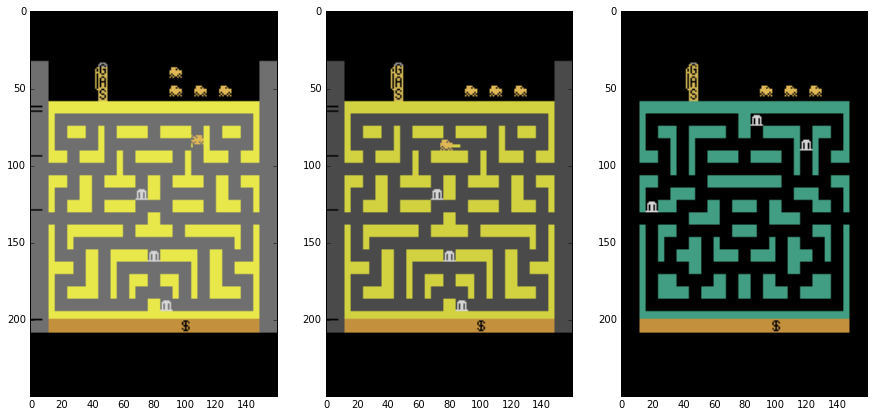

In [28]:
#visualize untrained network performance (which is mostly random)
display_sessions()

# Training loop

In [29]:
import os

In [30]:
from agentnet.display import Metrics
score_log = Metrics()

In [31]:
#starting epoch
epoch_counter = 1
#moving average estimation
alpha = 0.1
ma_reward_current = 0.
ma_reward_greedy = 0.

In [32]:
from agentnet.utils import save,load

In [33]:
#load(resolver,"/srv/hd7/jheuristic/agentnet_snapshots/heist.epoch7000")

In [34]:
resolver = controller.resolver

In [36]:
%%time

n_epochs = 25000
#25k may take hours to train.
#consider interrupt early.



for i in range(n_epochs):    
    
    
    #train
    update_envs(controller_env,metacontroller_env,pool,replay_seq_len)
    loss,avg_reward = train_fun()
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%1 ==0:
        current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%5 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        update_pool(env,pool,replay_seq_len)

        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))
        update_pool(env,pool,replay_seq_len)

        print("epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy))
        print("rec %.3f reg %.3f"%(q_loss,l2_penalty))

    if epoch_counter %500 ==0:
        print("Learning curves:")
        score_log.plot()


        print("Random session examples")
        display_sessions()
    
    if epoch_counter %1000 ==0:
        save(resolver,"/srv/hd7/jheuristic/agentnet_snapshots/{}.epoch{}".format("heist",epoch_counter))

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

ValueError: all the input array dimensions except for the concatenation axis must match exactly
Apply node that caused the error: Join(TensorConstant{1}, Reshape{5}.0, HostFromGpu.0)
Toposort index: 1859
Inputs types: [TensorType(int8, scalar), TensorType(float32, (False, True, False, False, False)), TensorType(float32, 5D)]
Inputs shapes: [(), (100, 1, 3, 125, 80), (10, 2, 3, 125, 80)]
Inputs strides: [(), (120000, 120000, 40000, 320, 4), (240000, 120000, 40000, 320, 4)]
Inputs values: [array(1, dtype=int8), 'not shown', 'not shown']
Outputs clients: [[Subtensor{::, :int64:}(Join.0, Constant{-1}), GpuFromHost(Join.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/jheuristic/yozhik/AgentNet/agentnet/agent/mdp_agent.py", line 351, in get_sessions
    theano_expressions = lasagne.layers.get_output(list(state_layers_dict.values()) + list(output_layers))
  File "/home/jheuristic/thenv/local/lib/python2.7/site-packages/lasagne/layers/helper.py", line 191, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "/home/jheuristic/yozhik/AgentNet/agentnet/agent/recurrence.py", line 301, in get_output_for
    n_steps=self.n_steps
  File "/home/jheuristic/thenv/local/lib/python2.7/site-packages/lasagne/utils.py", line 422, in unroll_scan
    out_ = fn(*step_input)
  File "/home/jheuristic/yozhik/AgentNet/agentnet/agent/recurrence.py", line 292, in step
    new_states, new_outputs = self.get_one_step(prev_states_dict, inputs_dict, **recurrence_flags)
  File "/home/jheuristic/yozhik/AgentNet/agentnet/agent/recurrence.py", line 431, in get_one_step
    **get_output_kwargs
  File "/home/jheuristic/thenv/local/lib/python2.7/site-packages/lasagne/layers/helper.py", line 191, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "/home/jheuristic/yozhik/AgentNet/agentnet/memory/window.py", line 48, in get_output_for
    new_window = T.concatenate([new_state, prev_window[:, :-1]], axis=1)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

# Evaluating results
 * Here we plot learning curves and sample testimonials

In [25]:
score_log.plot("final")

NameError: name 'score_log' is not defined

In [ ]:
print("Random session examples")
display_sessions()


# Submission
Here we simply run the OpenAI gym submission code and view scores

In [ ]:
resolver.epsilon.set_value(0)

In [ ]:
[m.close() for m in gym.monitoring._open_monitors()]

In [ ]:

save_path = '/tmp/AgentNet-simplenet-SpaceInvadersv0-Recording0'

subm_env = gym.make(GAME_TITLE)

#starting monitor. This setup does not write videos
#subm_env.monitor.start(save_path,lambda i: False,force=True)

#this setup does
subm_env.monitor.start(save_path,force=True)


for i_episode in xrange(10):
    
    #initial observation
    observation = subm_env.reset()
    #initial memory
    prev_memories = "zeros"
    
    
    t = 0
    while True:

        action,new_memories = step([observation],prev_memories,batch_size=1)
        observation, reward, done, info = subm_env.step(action[0])
        
        prev_memories = new_memories
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
        t+=1

subm_env.monitor.close()

In [ ]:

gym.upload(save_path,
           
           #this notebook
           writeup=<url to my gist>, 
           
           #your api key
           api_key=<my_own_api_key>)


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for examples? Try examples/Deep Kung Fu for most of these features


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__